In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
year = '2016'

In [3]:
df = pd.read_csv('data/points_against_'+year+'.csv')

In [4]:
# Calculate Team Against Ave/Std
for pos in df.Position.unique():
    df_pos = df[df.Position == pos]
    for team in df.Team_Against.unique():
        ave = df_pos.loc[(df.Team_Against == team) & (df.Game_Count==1)].Points_Against.astype(float).mean()
        std = df_pos.loc[(df.Team_Against == team) & (df.Game_Count==1)].Points_Against.astype(float).std()

        df.loc[(df.Team_Against == team) & (df.Position == pos), 'Against_Ave'] = ave
        df.loc[(df.Team_Against == team) & (df.Position == pos), 'Against_Std'] = std
        df['Against_16th'] = df['Against_Ave'] - df['Against_Std']
        df['Against_84th'] = df['Against_Ave'] + df['Against_Std']

In [5]:
df['Game_Dev'] = (df.Points_Against - df.Against_Ave)/(df.Against_Std)

In [6]:
# Check what is the best indicator
for pos in df.Position.unique():
    df_pos = df.loc[(df.Position == pos) & (df.Game_Count==1)]
    pos_std = df_pos.Points_Against.astype(float).std()
    for team in df.Team_Against.unique():
        for wk in df.Week.unique():
            if len(df_pos.loc[(df_pos.Team_Against == team) & (df_pos.Week == wk)].Points_Against.astype(float)) > 1:
                print(['Error:',df_pos.loc[(df_pos.Team_Against == team) & (df_pos.Week == wk)].Points_Against.astype(float)])
            act_ag = df_pos.loc[(df_pos.Team_Against == team) & (df_pos.Week == wk)].Points_Against.astype(float).mean()
            ave_ag = df_pos.loc[(df_pos.Team_Against == team) & (df_pos.Week != wk)].Points_Against.astype(float).mean()
            df.loc[(df.Team_Against == team) & (df.Position == pos) & (df.Week == wk),'Var_Against'] = (act_ag - ave_ag)/pos_std
            
            if len(df_pos.loc[(df_pos.VS == team) & (df_pos.Week == wk)].Points_Against.astype(float)) > 1:
                print(['Error:',df_pos.loc[(df_pos.VS == team) & (df_pos.Week == wk)].Points_Against.astype(float)])
            act_vs = df_pos.loc[(df_pos.VS == team) & (df_pos.Week == wk)].Points_Against.astype(float).mean()
            ave_vs = df_pos.loc[(df_pos.VS == team) & (df_pos.Week != wk)].Points_Against.astype(float).mean()
            df.loc[(df.VS == team) & (df.Position == pos) & (df.Week == wk),'Var_VS'] = (act_vs - ave_vs)/pos_std

In [7]:
pos = 'K'
print(['Against:',df.loc[df.Position==pos].Var_Against.abs().mean(),'VS:',df.loc[df.Position==pos].Var_VS.abs().mean()])

['Against:', 0.82135882462756438, 'VS:', 0.80086529297680908]


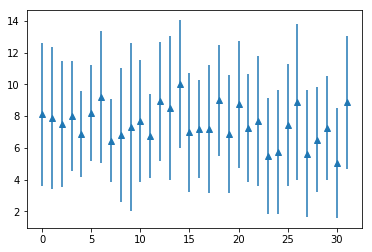

In [33]:
df_plt = df[['Team_Against','Position','Against_Std','Against_Ave']]
df_plt = df_plt.drop_duplicates()

pos = 'K'

df_plt = df_plt[df_plt.Position == pos]

plt.errorbar(range(len(df_plt['Team_Against'])), df_plt['Against_Ave'], df_plt['Against_Std'], linestyle='None', marker='^')
plt.show()

In [13]:
# Calculate Deviation from average
df['Game_Dev'] = (df.Points_Against - df.Against_Ave)/(df.Against_Std)

In [14]:
# Construct Summary DF from the 'VS' team perspective
df_vs = df[['VS','Position','Year']]
df_vs = df_vs.drop_duplicates()
df_vs = df_vs[df_vs.VS != 'Bye']

In [15]:
# Calculate Ave/Std (of deviations) for the VS teams
df_vs['VS_Ave'] = 0
df_vs['VS_Std'] = 0
for index, row in df_vs.iterrows():
    df_vs.loc[(df_vs['VS'] == row.VS) & (df_vs.Position == row.Position) & (df_vs.Year == row.Year),'VS_Ave'] = df[(df.VS == row.VS) & (df.Position == row.Position) & (df.Year == row.Year)].Game_Dev.mean()
    df_vs.loc[(df_vs['VS'] == row.VS) & (df_vs.Position == row.Position) & (df_vs.Year == row.Year),'VS_Std'] = df[(df.VS == row.VS) & (df.Position == row.Position) & (df.Year == row.Year)].Game_Dev.std()

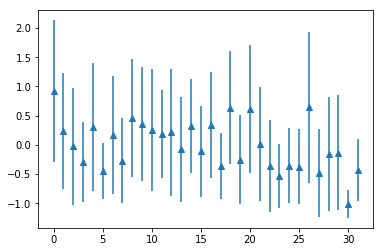

In [19]:
df_plt = df_vs[['VS','Position','VS_Std','VS_Ave']]
df_plt = df_plt.drop_duplicates()

pos = 'TE'

df_plt = df_plt[df_plt.Position == pos]

plt.errorbar(range(len(df_plt['VS'])), df_plt['VS_Ave'], df_plt['VS_Std'], linestyle='None', marker='^')
plt.show()

In [8]:
# Predict scores in a matchup
def matchup(team_against, vs):
    df_against = df[(df['Team_Against'] == team_against)][['Team_Against','Position','Against_Ave','Against_Std','Against_16th','Against_84th']]
    df_against = df_against.drop_duplicates()
    
    df_matchup = pd.merge(left=df_against, right=df_vs[df_vs['VS']==vs], left_on='Position', right_on='Position')
    
    df_matchup['Weighted_16th'] = (df_matchup['VS_Ave']-df_matchup['VS_Std'])*df_matchup['Against_Std']+df_matchup['Against_Ave']
    df_matchup['Weighted_Mean'] = (df_matchup['VS_Ave'])*df_matchup['Against_Std']+df_matchup['Against_Ave']
    df_matchup['Weighted_84th'] = (df_matchup['VS_Ave']+df_matchup['VS_Std'])*df_matchup['Against_Std']+df_matchup['Against_Ave']
    
    return df_matchup
    

In [9]:
matchup('LA', 'SF')

,Team_Against,Position,Against_Ave,Against_Std,Against_16th,Against_84th,VS,Year,VS_Ave,VS_Std,Weighted_16th,Weighted_Mean,Weighted_84th
0,LA,QB,17.68250,8.382067,9.300433,26.064567,SF,2016,-0.006174,0.852379,10.486049,17.630746,24.775443
1,LA,RB,17.87500,11.279879,6.595121,29.154879,SF,2016,0.080498,0.896055,8.675619,18.783005,28.890391
2,LA,WR,25.39375,12.192364,13.201386,37.586114,SF,2016,-0.858803,0.471785,9.170728,14.922906,20.675084
3,LA,TE,6.00625,5.581344,0.424906,11.587594,SF,2016,0.170491,1.016603,1.283810,6.957819,12.631828
4,LA,K,5.75000,4.032041,1.717959,9.782041,SF,2016,-0.417904,0.569246,1.769774,4.064996,6.360218
5,LA,DEF,12.00000,7.597407,4.402593,19.597407,SF,2016,-0.566172,0.512775,3.802796,7.698558,11.594320


In [10]:
schedule_year = 2017
df_schedule = pd.read_csv('data/schedule_'+str(schedule_year)+'.csv')
def get_week(wk):
    df_tmp = df_schedule[df_schedule['Week'] == wk].copy()

    df_tmp['Team1'] = df_tmp['Away']
    df_tmp['Team2'] = df_tmp['Home']
    df_week = pd.DataFrame()
    df_week['Team1'] = df_tmp['Home']
    df_week['Team2'] = df_tmp['Away']
    df_week = pd.concat([df_tmp,df_week])[['Team1','Team2']].reset_index(drop=True)
    return df_week

In [20]:
wk = 4

In [21]:
df_week = get_week(wk)
df_wk_matchups = pd.DataFrame()
for i in range(len(df_week)):
    
    df_tmp = matchup(df_week.Team1[i], df_week.Team2[i])[['VS','Team_Against','Position','Weighted_16th','Weighted_Mean','Weighted_84th']]
    df_wk_matchups = pd.concat([df_wk_matchups,df_tmp])

In [26]:
df_wk_matchups[df_wk_matchups.Position=='QB'].sort_values('Weighted_Mean',ascending=False)

,VS,Team_Against,Position,Weighted_16th,Weighted_Mean,Weighted_84th
0,NO,MIA,QB,14.043809,24.416230,34.788651
0,GB,CHI,QB,17.694560,24.195501,30.696442
0,ATL,BUF,QB,15.589731,21.175710,26.761689
0,NE,CAR,QB,13.295417,20.823569,28.351722
0,BUF,ATL,QB,11.762672,20.044739,28.326807
0,CIN,CLE,QB,16.191790,19.817193,23.442596
0,DAL,LA,QB,13.233669,19.802542,26.371414
0,WAS,KC,QB,10.766626,19.370096,27.973566
0,SEA,IND,QB,9.296033,18.046572,26.797111
0,JAX,NYJ,QB,11.156297,17.564011,23.971725
